In [1]:
import glob
import json
import numpy as np
import os

import boto3
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
from pycocotools.coco import COCO
from skimage.io import imread

%matplotlib inline

# set pandas options
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)


/usr/local/lib/python3.5/dist-packages/pycocotools/coco.py:49: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platfo

<h1> Load crop dataset </h1>

In [2]:
analysis_df_annotations_path = '/root/data/alok/crop_data/data_dumps/new_optics_annotations.csv'
analysis_df_annotations_reconciled_path = '/root/data/alok/crop_data/data_dumps/new_optics_annotations_reconciled.csv'
analysis_df_annotations = pd.read_csv(analysis_df_annotations_path)
analysis_df_reconciled_annotations = pd.read_csv(analysis_df_annotations_reconciled_path)

features = ['created_by', 'adult_female_count_adjusted', 'image_width_px', 'image_height_px', 'is_too_dark', 'metadata']

analysis_df = pd.concat([analysis_df_annotations[features], analysis_df_reconciled_annotations[features]], axis=0)

# compute crop size and aspect ratio 
analysis_df['crop_size'] = analysis_df.image_width_px * analysis_df.image_height_px
analysis_df['aspect_ratio'] = analysis_df.image_width_px / analysis_df.image_height_px
analysis_df = analysis_df[~analysis_df.metadata.isnull()].copy(deep=True)
analysis_df['mean_luminance'] = analysis_df.metadata.apply(lambda x: json.loads(x)['mean_luminance'])

<h3> Visualize crop size for crops that were accepted in QA vs. rejected by Cogito </h3>

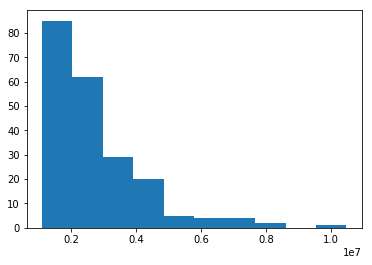

In [32]:
# crop size histogram for crops that are accepted in QA

accepted_mask = (analysis_df.created_by == 'gunnar@aquabyte.ai') & (analysis_df.adult_female_count_adjusted >= 0)
plt.hist(analysis_df[accepted_mask].crop_size)
plt.show()


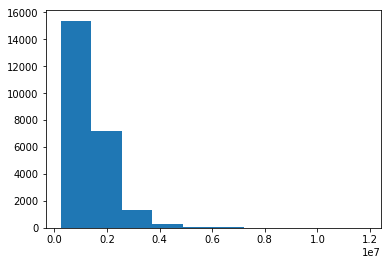

In [33]:
# crop size histogram for crops that are rejected by Cogito

# rejected_mask = (analysis_df.is_skipped == True)
rejected_mask = analysis_df.adult_female_count_adjusted.isnull()
plt.hist(analysis_df[rejected_mask].crop_size)
plt.show()

<h3> Visualize aspect ratio for crops that were accepted in QA versus rejected by Cogito </h3>

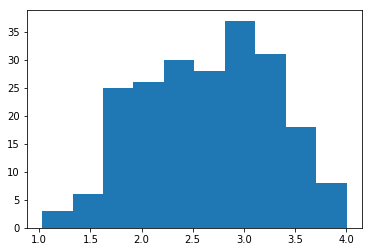

In [34]:
# aspect ratio histogram for crops that are accepted in QA

accepted_mask = (analysis_df.created_by == 'gunnar@aquabyte.ai') & (analysis_df.adult_female_count_adjusted >= 0)
plt.hist(analysis_df[accepted_mask].aspect_ratio)
plt.show()


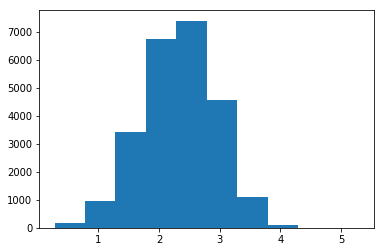

In [35]:
# aspect ratio histogram for crops that are rejected by Cogito

# rejected_mask = (analysis_df.is_skipped == True)
rejected_mask = analysis_df.adult_female_count_adjusted.isnull()
plt.hist(analysis_df[rejected_mask].aspect_ratio)
plt.show()

<h1> Create precision / recall curve for training data </h1>

<h3> Define positive outcome as a crop being rejected due to size threshold, and negative outcome as crop being accepted </h3>

In [31]:
true_negative_mask = (analysis_df.created_by == 'gunnar@aquabyte.ai') & (analysis_df.adult_female_count_adjusted >= 0)
true_positive_mask = analysis_df.adult_female_count_adjusted.isnull()

metric = 'crop_size'
thresholds = np.percentile(analysis_df[metric], list(range(100)))
precisions, recalls = [], []
for t in thresholds:
    positive_predictions_mask = (analysis_df[metric] < t) & ((true_negative_mask) | (true_positive_mask))
    negative_predictions_mask = (analysis_df[metric] > t) & ((true_negative_mask) | (true_positive_mask))
    if analysis_df[positive_predictions_mask].shape[0] > 0:
        precision = analysis_df[positive_predictions_mask & true_positive_mask].shape[0] / \
                    analysis_df[positive_predictions_mask].shape[0]
        recall = analysis_df[positive_predictions_mask & true_positive_mask].shape[0] / \
                    analysis_df[true_positive_mask].shape[0]
        precisions.append(precision)
        recalls.append(recall)
    
    

In [28]:
true_positive_mask = (analysis_df.created_by == 'gunnar@aquabyte.ai') & (analysis_df.adult_female_count_adjusted >= 0)
true_negative_mask = analysis_df.adult_female_count_adjusted.isnull()

metric = 'crop_size'
thresholds = np.percentile(analysis_df[metric], list(range(100)))
precisions, recalls = [], []
for t in thresholds:
    positive_predictions_mask = (analysis_df[metric] > t) & ((true_negative_mask) | (true_positive_mask))
    negative_predictions_mask = (analysis_df[metric] < t) & ((true_negative_mask) | (true_positive_mask))
    if analysis_df[negative_predictions_mask].shape[0] > 0:
        precision = analysis_df[positive_predictions_mask & true_positive_mask].shape[0] / \
                    analysis_df[positive_predictions_mask].shape[0]
        recall = analysis_df[positive_predictions_mask & true_positive_mask].shape[0] / \
                    analysis_df[true_positive_mask].shape[0]
        precisions.append(precision)
        recalls.append(recall)
    
    

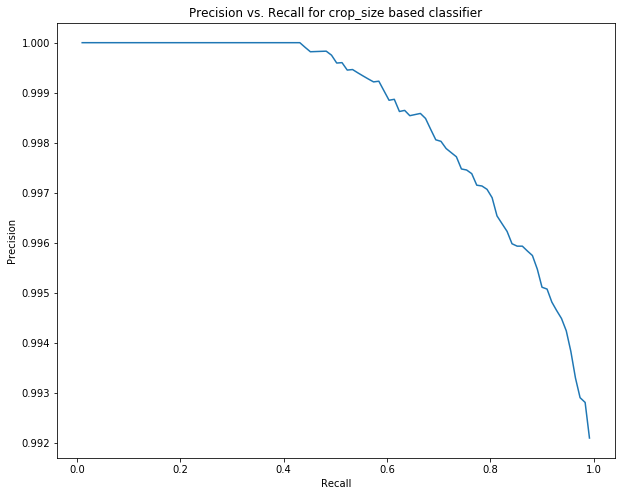

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall for {} based classifier'.format(metric))
plt.show()

In [30]:
for t, p, r in list(zip(thresholds, precisions, recalls)):
    print(t, p, r)

251835.0 0.008695295517000943 1.0
414523.22000000003 0.008785743887277249 1.0
464010.72000000003 0.008878093722517693 1.0
499313.39999999997 0.008972405620450314 1.0
527581.36 0.009068742781366301 1.0
552851.5 0.009167171149355703 1.0
574859.04 0.00926775956284153 1.0
595825.4400000001 0.00937057991513437 1.0
612954.24 0.009475707325794485 1.0
631499.4 0.009583220323659705 1.0
646693.6 0.009693644261545497 1.0
660450.0 0.009805735430157262 1.0
676259.28 0.009920913472787684 1.0
689992.38 0.01003882943460555 1.0
704603.6799999999 0.010159582115301673 1.0
718140.1 0.010283275126115638 1.0
732648.16 0.010410017186349128 1.0
747572.8 0.010539922442080144 1.0
761796.6399999999 0.010673648172389487 1.0
776620.0 0.010809708341831531 1.0
792519.2 0.0109498476318372 1.0
808433.1399999999 0.01109366823652538 1.0
823182.96 0.011241317143008644 1.0
837316.3200000001 0.01139356156285269 1.0
851904.0 0.011548098921451139 1.0
866075.0 0.011706886078745374 1.0
881127.4400000001 0.011871430171351775 1.

In [41]:
too_mask_mask = (analysis_df['crop_size'] < 936919.0)
too_dark_mask = (analysis_df['mean_luminance'] < 20)
analysis_df[too_mask_mask & (~too_dark_mask)].shape[0] / analysis_df.shape[0]


0.22984979481254234

In [15]:
analysis_df[(~true_positive_mask) & (~true_negative_mask)]

,created_by,adult_female_count_adjusted,image_width_px,image_height_px,is_too_dark,metadata,crop_size,aspect_ratio,mean_luminance
91,labeler3@cogitotech.com,2.0,2809,2731,NaN,"{""mean_luminance"": 60.69835372404949, ""luminance_version"": ""2019-01-21T23:00:00z""}",7671379,1.028561,60.698354
217,labeler3@cogitotech.com,0.0,2452,914,NaN,"{""mean_luminance"": 34.26001152037773, ""luminance_version"": ""2019-01-21T23:00:00z""}",2241128,2.682713,34.260012
289,labeler4@cogitotech.com,0.0,2659,1235,NaN,"{""mean_luminance"": 40.018873689046345, ""luminance_version"": ""2019-01-21T23:00:00z""}",3283865,2.153036,40.018874
479,labeler5@cogitotech.com,0.0,1913,796,NaN,"{""mean_luminance"": 30.926063947715946, ""luminance_version"": ""2019-01-21T23:00:00z""}",1522748,2.403266,30.926064
492,labeler5@cogitotech.com,0.0,1620,1026,NaN,"{""mean_luminance"": 24.96168079457083, ""luminance_version"": ""2019-01-21T23:00:00z""}",1662120,1.578947,24.961681
496,labeler2@cogitotech.com,0.0,2561,896,NaN,"{""mean_luminance"": 34.00269698503855, ""luminance_version"": ""2019-01-21T23:00:00z""}",2294656,2.858259,34.002697
550,labeler4@cogitotech.com,0.0,2063,796,NaN,"{""mean_luminance"": 22.253871914829645, ""luminance_version"": ""2019-01-21T23:00:00z""}",1642148,2.591709,22.253872
582,labeler5@cogitotech.com,0.0,1762,961,NaN,"{""mean_luminance"": 18.263127569860934, ""luminance_version"": ""2019-01-21T23:00:00z""}",1693282,1.833507,18.263128
626,labeler3@cogitotech.com,0.0,2287,627,NaN,"{""mean_luminance"": 38.427628608467934, ""luminance_version"": ""2019-01-21T23:00:00z""}",1433949,3.647528,38.427629
687,labeler4@cogitotech.com,0.0,2365,1295,NaN,"{""mean_luminance"": 27.16832564799785, ""luminance_version"": ""2019-01-21T23:00:00z""}",3062675,1.826255,27.168326


<h1> Investigate bad cases </h1>

In [ ]:
threshold = np.percentile(analysis_df.crop_size, list(range(100)))[5]
false_positive_mask = positive_predictions_mask & ~true_positive_mask
tdf = analysis_df[false_positive_mask].sort_values('crop_size', ascending=True).head(10)
tdf


In [ ]:
coco = COCO()
coco.imgs = [
    {
        'height': 3000,
        'width': 4096
    }
]

In [ ]:
i = 1
image_f = tdf.image_path.iloc[i]
im = Image.open(image_f)
ann = {
    'image_id': 0,
    'segmentation': json.loads(tdf.segmentation.iloc[i])['segmentation']
}
m = coco.annToMask(ann)



In [ ]:
im

In [ ]:
Image.fromarray(np.array(im.convert('L')) * m)